# This code implements Logistic Regression to classify fatal road collisions in Angeles (Public data by Los Angeles Traffic department)

In [22]:
import pandas as pd, numpy as np

In [2]:
#Reading in the data
LA_df=pd.read_csv('/Users/Haridut/Documents/visionzero -LA/Collisions_LA_2009-13.csv')

In [3]:
#We select Time category, Day of the week, Intersection, Type of collision, alcohol , primary reason for collision,
#Pedestrian's actions as features and number of people killed as target
Logistic_df=LA_df[['TIMECAT','DAY_OF_WEEK','INTERSECTION','TYPE_OF_COLLISION','ALCOHOL_INVOLVED','PRIMARY_COLL_FACTOR','PED_ACTION','NUMBER_KILLED']]

In [4]:
#After analyzing all the features, it was found alcohol had missing values. We filled in the missing values 
# with 'N' indicating 'No Alcohol consumed' since it is the majority class.
def fill_missing(x):
    if pd.isnull(x):
        return 'N'
    else:
        return 'Y'
Logistic_df['ALCOHOL_INVOLVED']=Logistic_df['ALCOHOL_INVOLVED'].apply(lambda x: fill_missing(x))  

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#Lots of entries are '-'. We select only those rows where none of the features have value as '-'.
Logistic_df=Logistic_df[(Logistic_df['INTERSECTION']!='-') & (Logistic_df['TYPE_OF_COLLISION']!='-') & (Logistic_df['PRIMARY_COLL_FACTOR']!='-') & (Logistic_df['PED_ACTION']!='-')]

In [6]:
#The goal of our logistic regression classification is to preict whethere there was a fatality given the circumstances
# Hence, transformed the 'NUMBER_KILLED' column with 1 indicating fatality and 0 indicating no fatality
def fatality(x):
    if x>0:
        return 1
    else:
        return 0
Logistic_df['NUMBER_KILLED']=Logistic_df['NUMBER_KILLED'].apply(lambda x: fatality(x))

In [7]:
Logistic_df['NUMBER_KILLED'].value_counts()
#We can see that the fatality instances are just a fraction of the incidents. Hence, the data is largely imbalanced
#To overcome this we adopt a technique called Synthetic Minority Over Sampling (SMOTE) which gives us more fatality
# instances. This part was done in R as python's SMOTE library requires features to be continuous.

0    168682
1       870
Name: NUMBER_KILLED, dtype: int64

In [8]:
#We write this to an excel file
Logistic_df.to_csv('/Users/Haridut/Documents/visionzero -LA/Logistic_df.csv')

In [9]:
#After performing SMOTE, we import the data
After_smote=pd.read_csv('/Users/Haridut/Documents/visionzero -LA/After_SMOTE.csv')

In [10]:
After_smote['NUMBER_KILLED'].value_counts()
#Now, the fatality instances are well represented 

0    17400
1     9570
Name: NUMBER_KILLED, dtype: int64

In [11]:
# We'll use pd.get_dummies to convert the categorical variables into indicator variables. To use pd.get_dummies we
# need the features to be of the type 'object'. So, we convert all columns into object type.
for i in ['TIMECAT','DAY_OF_WEEK','INTERSECTION','TYPE_OF_COLLISION','ALCOHOL_INVOLVED','PRIMARY_COLL_FACTOR','PED_ACTION','NUMBER_KILLED']:
    After_smote[i]=After_smote[i].astype(object)

In [12]:
# Transforming into indicator variables. For any feature with 'n' attributes, there would be 'n-1' columns as one value 
# would be redundant. It is understood that if it is not 'Male' , it is 'Female' for example.
After_smote=pd.get_dummies(After_smote,drop_first=True)
#Look at how the teble is split up.
print(After_smote.head(3).iloc[:,:8])
#Renaming the target variable
After_smote=After_smote.rename(columns={"NUMBER_KILLED_1":"KILLED?"})

   TIMECAT_600  TIMECAT_900  TIMECAT_1200  TIMECAT_1500  TIMECAT_1800  \
0            0            0             0             1             0   
1            0            0             0             0             0   
2            0            0             0             0             1   

   TIMECAT_2100  TIMECAT_2400  DAY_OF_WEEK_2  
0             0             0              0  
1             1             0              0  
2             0             0              0  


In [13]:
#Splitting the features and target variables
X_after_smote=After_smote.drop('KILLED?',axis=1)
y_after_smote=After_smote['KILLED?']
#Dividing the datset into training and test data set by train_test_split method in sklearn
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_after_smote,y_after_smote,random_state=0)

In [14]:
#Performing a Grid Search over different regularization parameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid={'penalty':['l1','l2'],'C':[0.01,0.1,1,10,100]}
grid_clf_recall=GridSearchCV(LogisticRegression(random_state=0),param_grid=param_grid,scoring='recall',cv=3)
grid_clf_recall.fit(X_train,y_train)
print('Grid best parameter (max. accuracy): ', grid_clf_recall.best_params_)
print('Grid best score (recall): ', grid_clf_recall.best_score_)

Grid best parameter (max. accuracy):  {'C': 10, 'penalty': 'l1'}
Grid best score (recall):  0.737310252044


In [15]:
#Implementing Logistic Regression
from sklearn.linear_model import LogisticRegression
#Training the classifier on traing set.
Logistic=LogisticRegression(penalty='l1',C=10.0).fit(X_train,y_train)
#Accuracy on the test set (But Accuracy does not mean much in this case, instead we need one that scores good on recall and precision)
print('Accuracy with which Logistic Regression predicts a fatality: {:.3f}'.format(Logistic.score(X_test,y_test)))

Accuracy with which Logistic Regression predicts a fatality: 0.842


In [16]:
#Performing 5-fold cross validation test to calculate the precision and recall
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
scores_recall=cross_val_score(LogisticRegression(penalty='l1',C=10.0),X_after_smote,y_after_smote,cv=5,scoring='recall')
scores_precision=cross_val_score(Logistic,X_after_smote,y_after_smote,cv=5,scoring='precision')
print("Cross Validation Recall for C=10: " + "%0.3f (+/- %0.3f)" % (scores_recall.mean(), scores_recall.std() * 2))
print("Cross Validation Precision for C=10: " + "%0.3f (+/- %0.3f)\n\n" % (scores_precision.mean(), scores_precision.std() * 2))
#The logistic regression does a fair job in classifying if there was a fatality or not

Cross Validation Recall for C=10: 0.736 (+/- 0.061)
Cross Validation Precision for C=10: 0.792 (+/- 0.027)




In [17]:
# Output Confusion Matrix on test set 
from sklearn.metrics import confusion_matrix
predictions=Logistic.predict(X_test)
print ('Confusion Matrix: \n')
cf=confusion_matrix(y_test,predictions)
print('True Negatives: '+str(cf[0][0]))
print('True Positives: '+str(cf[1][1]))
print('False Positives: '+str(cf[0][1]))
print('False Negative: '+str(cf[1][0]))
print('There are ' +str(cf[1][0]) + ' cases out of the '+str(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0]) +' cases where there was a fatality but \nlogistic regression predicted no fatality')
# Output a classification report with precision and recall
from sklearn.metrics import classification_report
target_names = ['class 0','class 1']
print('\n \n Classification Report: \n')
print(classification_report(y_test,predictions,target_names=target_names))


Confusion Matrix: 

True Negatives: 3923
True Positives: 1754
False Positives: 441
False Negative: 625
There are 625 cases out of the 6743 cases where there was a fatality but 
logistic regression predicted no fatality

 
 Classification Report: 

             precision    recall  f1-score   support

    class 0       0.86      0.90      0.88      4364
    class 1       0.80      0.74      0.77      2379

avg / total       0.84      0.84      0.84      6743



/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


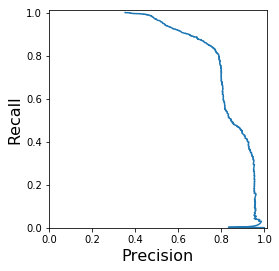

In [18]:
#Precision Recall curve for different thresholds
from sklearn.metrics import precision_recall_curve,roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline
y_scores_lr = Logistic.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision,recall,label='Precsion-Recall Curve')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


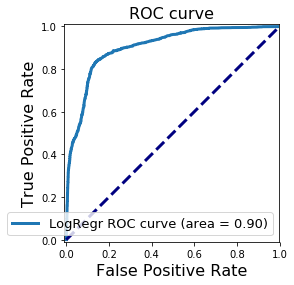

In [19]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

#AUC = 90% which is very good, indicating that False positive rate is low compared to true positive rate

In [21]:
odds_ratio=np.exp(Logistic.coef_[0])
attribute_fatality_imp = odds_ratio.argsort()[::-1][:10]
print('The most important factors that forces the classifier towards predicting a death:\n')
for i in attribute_fatality_imp:
    print (str(X_after_smote.columns[i]) +' : ' + str(odds_ratio[i]))
print('\nFor Example, the odds of a fatality is 7.6 times more when alcohol is involved compared to when alcohol is not involved\n')

The most important factors that forces the classifier towards predicting a death:

PED_ACTION_F : 8.41020738759
ALCOHOL_INVOLVED_Y : 7.59346590636
PED_ACTION_E : 5.90786372228
PED_ACTION_D : 4.88494003612
PED_ACTION_C : 4.58960973213
TYPE_OF_COLLISION_G : 4.52979232067
PED_ACTION_B : 4.51222714733
PRIMARY_COLL_FACTOR_D : 3.87477074121
TYPE_OF_COLLISION_F : 2.67954009791
PRIMARY_COLL_FACTOR_B : 2.54589887182

For Example, the odds of a fatality is 7.6 times more when alcohol is involved compared to when alcohol is not involved

